# Machine Learning for Email Spam Filter
Dataset:
Goal:
Attributes: 
    Email content
    Label(spam/ham)
Outline:

# Initial Setup

### Import Modules

In [21]:
import pandas as pd
import numpy as np
import string
import re

import nltk
from nltk.corpus import stopwords
# Import Scikit-learn helper functions
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import Scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score, precision_score

# Import Scikit-learn metric functions
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



### Loading the dataset

In [2]:
df = pd.read_csv(r"fyp_dataset.csv",encoding='latin1')
#df.head()
df.shape

(60986, 2)

# Prepocessing




#### URL extraction


In [143]:
def url_ex(dfrow):
    url = re.findall("(http[-a-zA-Z0-9@:%_\+.~#?&//=]*)",dfrow['body'])
    if len(url) > 0:
        dfrow['url'] = url[0]
    else:
        dfrow['url'] = None
    return dfrow

In [20]:
dfurl = df.apply(url_ex,axis=1)

#### StopWord Remove & Tokenization

In [21]:
def preprocess(body):
    #Convert to lowercase 
    lower_body = body.lower() 
    #Remove punctuation
    nonpunc = ''.join(char for char in lower_body if char not in string.punctuation)
    #Remove extra spaces
    nonspace = re.sub(r'\s+', ' ', nonpunc)
    #Remove stopwords
    clean_body = ' '.join(word for word in nonspace.split() if word not in stopwords.words('english'))
    #Tokenization
    clean_body = nltk.word_tokenize(clean_body)
    return clean_body

In [22]:
# clean the messages
dfurl['clean_body'] = dfurl['body'].apply(preprocess)

In [23]:
#Drop the null body
def drop_null(processdf):
    count = processdf['clean_body'].count()
    drop_list = []
    for i in range(count):
        blen = len(list(processdf['clean_body'])[i])
        if blen == 0:
            drop_list.append(i)
            print(i)
        else:
            pass
    return processdf.drop(drop_list)

In [24]:
df2 = drop_null(dfurl)
df2.to_csv('tocken(preprocess).csv', index=False)
#drop all rows with None values
df2 = df2.dropna()
df2.to_csv('tocken(preprocess_dropnaURL).csv', index=False)

11
18
19
20
25
46
51
55
64
79
91
92
106
118
122
132
134
135
163
200
207
218
283
351
352
414
415
424
426
536
541
542
547
551
555
636
668
680
694
753
795
940
960
970
1149
1241
1242
1285
1315
1350
1351
1390
1399
1447
1497
1543
1545
1611
1614
1670
1721
1824
1829
1836
1870
1874
1890
1893
1899
1977
2006
2023
2031
2113
2184
2215
2251
2275
2276
2306
2318
2326
2334
2407
2409
2413
2456
2461
2481
2513
2517
2548
2588
2640
2668
2678
2679
2680
2697
2703
2755
2757
2787
2806
2820
2836
2920
3019
3079
3142
3147
3174
3201
3218
3259
3272
3281
3284
3305
3338
3381
3412
3427
3445
3458
3475
3613
3614
3615
3631
3704
3712
3713
3746
3752
3754
3761
3807
3820
3939
3941
3942
3976
4030
4130
4150
4230
4233
4237
4264
4316
4321
4361
4384
4433
4451
4499
4502
4511
4517
4525
4582
4647
4949
4963
6499
6826
7272
7277
7282
7286
7296
7306
7330
7338
7408
7413
7429
7508
7547
7686
7693
7699
7756
7764
7768
7778
7796
7822
7864
7869
7871
7900
7909
7911
7935
7936
7966
7985
7991
8038
8043
8061
8075
8088
8111
8114
8147
8160
8249
8251
8

You can start from here to save the time for preprocessing

In [142]:
from ast import literal_eval
df2 = pd.read_csv(r"tocken(preprocess_dropnaURL).csv",encoding='latin1',converters={'clean_body': literal_eval})
type(df2['clean_body'][0])

list

In [3]:
# check for null values
df2.isnull().sum()

body          0
label         0
url           0
clean_body    0
dtype: int64

spam    15332
ham     13940
Name: label, dtype: int64


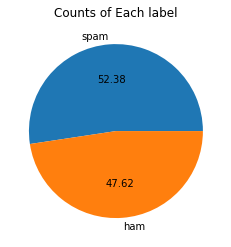

In [4]:
# Print counts of each label
print(df2['label'].value_counts())
plt.pie(df2['label'].value_counts(), labels=['spam','ham'],autopct="%0.2f")
plt.title('Counts of Each label')
plt.show()

# Feature Engineer

In [8]:
df3 = df2.copy()
df3.head()

,body,label,url,clean_body
0,"Hey Billy, \n\nit was really fun going out the...",spam,http://ctmay.com,"[hey, billy, really, fun, going, night, talkin..."
1,Hi...\n\nI have to use R to find out the 90% c...,ham,http://www.nabble.com/Confidence-Intervals.......,"[hi, use, r, find, 90, confidenceinterval, sen..."
2,"Hey Billy, \n\nit was really fun going out the...",spam,http://ctmay.com,"[hey, billy, really, fun, going, night, talkin..."
3,Hm... sounds like a homework problem to me...\...,ham,http://www.functionaldiversity.org,"[hm, sounds, like, homework, problem, maybe, s..."
4,Gruesse!\n* V.Harishankar schrieb am [08.04.0...,ham,http://www.debian.org/releases/stable/i386/rel...,"[gruesse, vharishankar, schrieb, 080407, 0649,..."


In [6]:
#Searching the most freq words in spam & ham email
from nltk.probability import FreqDist

spamlist = []
hamlist = []
for i in range(len(df3)):
    if df3['label'][i] == 'spam':
        spamlist.extend(df3['clean_body'][i])
    else:
        hamlist.extend(df3['clean_body'][i])

spamfreq = FreqDist(spamlist).most_common()
hamfreq = FreqDist(hamlist).most_common()
print('Top 10 Spam Freq word',[spamfreq[i] for i in range(0,10)],'\nTop 10 Ham Freq word',[hamfreq[i] for i in range(0,10)])

Top 10 Spam Freq word [('desjardins', 43271), ('de', 27364), ('votre', 20862), ('vous', 18185), ('le', 14598), ('que', 10838), ('et', 10822), ('les', 10191), ('fontsize', 9810), ('pas', 9682)] 
Top 10 Ham Freq word [('1', 15019), ('list', 14436), ('0', 13481), ('mailing', 11261), ('code', 11184), ('please', 9739), ('read', 9505), ('r', 8845), ('email', 8458), ('use', 8393)]


### Body Feature

In [9]:
#Count the Length of Email Body
#return numeric of the Length of Body
def bodyLen_num(df):
    Len_count = len(df['clean_body'])
    return Len_count
#Count the total number of unique words in Email Body
#return numeric of the unique words in Email Body
def bodyUniWord_num(df):
    UniWord_count = []
    for i in df['clean_body']:
        if i not in UniWord_count:
            UniWord_count.append(i)
    return len(UniWord_count)
#Check if the Email Body including the spam' Freq Words
#return 1 mean found spam' Freq Words in Email Body
#desjardins|de|votre|vous|le|que|et|les|fontsize|pas
def bodySpamFreqWords(df):
    sfw = str(df['clean_body'])
    sfw = re.findall('desjardins|votre|vous',sfw)
    if bool(sfw) == True:
        return 1
    else:
        return  0  
#Check if the Email Body including the 'Dear' Word
#return 1 mean found 'Dear' Words in Email Body
def bodyDearWords(df):
    dw = str(df['clean_body'])
    dw = re.findall('dear',dw)
    if bool(dw) == True:
        return 1
    else:
        return  0
#Check if the Email Body including HTML format
#return 1 mean found HTML format in Email Body.
def bodyHtmlForm(df):
    hf = str(df['clean_body'])
    hf = re.findall('style1|style2|fontfamily|fontsize|\d{1,3}px',hf)
    if bool(hf) == True:
        return 1
    else:
        return  0
#Check if the Email Body including Login Words
#return 1 mean found Login Words in Email Body.
def bodyLoginWords(df):
    lw = df['url']
    lw = re.findall('login|signin|signup',lw)
    if bool(lw) == True:
        return 1
    else:
        return  0  
#Check if the Email Body including Finance Words
#return 1 mean found Finance Words in Email Body.
def bodyFinanceWords(df):
    fw = str(df['clean_body'])
    fw = re.findall('paypal|bank|payment|account|statement|credit',fw)
    if bool(fw) == True:
        return 1
    else:
        return  0   
#Check if the Email Body including Sensitive Words
#return 1 mean found Sensitive Words in Email Body.
def bodySensitiveWords(df):
    sw = df['url']
    sw = re.findall('reset|verify|promotion|password|denied',sw)
    if bool(sw) == True:
        return 1
    else:
        return  0  

In [10]:
df3['bodyLen_num'] = df3.apply(bodyLen_num,axis=1)
df3['bodyUniWord_num'] = df3.apply(bodyUniWord_num,axis=1)
df3['bodySpamFreqWords'] = df3.apply(bodySpamFreqWords,axis=1)
df3['bodyDearWords'] = df3.apply(bodyDearWords,axis=1)
df3['bodyHtmlForm'] = df3.apply(bodyHtmlForm,axis=1)
df3['bodyLoginWords'] = df3.apply(bodyLoginWords,axis=1)
df3['bodyFinanceWords'] = df3.apply(bodyFinanceWords,axis=1)
df3['bodySensitiveWords'] = df3.apply(bodySensitiveWords,axis=1)

### URL Feature

In [13]:
#Count the Length of URL
#return numeric of the Length of URL
def urlLen_num(df):
    Len_count =  len(df['url'])
    return Len_count
#Count the character '.' in URL
#return numeric of how many dot in URL
def urlDot_num(df):
    dot_count =  df['url'].count('.')
    return dot_count
#Count the depth of URL
#return numeric of how depth of the path in URL
def urlPathLevel_num(df):
    path_count =  df['url'].count('/')
    return path_count
#Count the character '-' in URL
#return numeric of how many Dash in URL
def urlDash_num(df):
    dash_count =  df['url'].count('-')
    return dash_count
#Count the character '_' in URL
#return numeric of how many underscore in URL
def urlUnderscore_num(df):
    underscore_count =  df['url'].count('_')
    return underscore_count
#Count the character '%' in URL
#return numeric of how many Percent in URL
def urlPercent_num(df):
    Percent_count =  df['url'].count('%')
    return Percent_count
#Count the character '&' in URL
#return numeric of how many Ampersand in URL
def urlAmpersand_num(df):
    Ampersand_count =  df['url'].count('&')
    return Ampersand_count
#Count the character '#' in URL
#return numeric of how many Hash in URL
def urlHash_num(df):
    Hash_count =  df['url'].count('#')
    return Hash_count

#Check it was HTTP or HTTPS 
#return 1 mean the URL display as http only
def urlHttp(df):
    http = df['url']
    http = re.findall('http://',http)
    if bool(http) == True:
        return 1
    else:
        return  0           
#Check if the URL Showing as IP address
#return 1 mean the URL display as IPv4 address
def urlIpAddress(df):
    ip = df['url']
    ip = re.findall('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}',ip)
    if bool(ip) == True:
        return 1
    else:
        return  0  
#Check if the URL Showing word realted to Login
#return 1 mean found word 'Login' in URL
def urlLoginWords(df):
    lw = df['url']
    lw = re.findall('login|signin|signup',lw)
    if bool(lw) == True:
        return 1
    else:
        return  0  
#Check if the URL Showing word realted to Finance
#return 1 mean found Finance Words in URL
def urlFinanceWords(df):
    fw = df['url']
    fw = re.findall('paypal|banking|payment|account',fw)
    if bool(fw) == True:
        return 1
    else:
        return  0  
#Check if the URL Showing word was Senetive
#return 1 mean found Senetive Words in URL
def urlSensitiveWords(df):
    sw = df['url']
    sw = re.findall('reset|verify|promotion|redirect',sw)
    if bool(sw) == True:
        return 1
    else:
        return  0  

In [14]:
df3['urlLen_num'] = df3.apply(urlLen_num,axis=1)
df3['urlDot_num'] = df3.apply(urlDot_num,axis=1)
df3['urlPathLevel_num'] = df3.apply(urlPathLevel_num,axis=1)
df3['urlDash_num'] = df3.apply(urlDash_num,axis=1)
df3['urlUnderscore_num'] = df3.apply(urlUnderscore_num,axis=1)
df3['urlPercent_num'] = df3.apply(urlPercent_num,axis=1)
df3['urlAmpersand_num'] = df3.apply(urlAmpersand_num,axis=1)
df3['urlHash_num'] = df3.apply(urlHash_num,axis=1)
df3['urlHttp'] = df3.apply(urlHttp,axis=1)
df3['urlIpAddress'] = df3.apply(urlIpAddress,axis=1)
df3['urlLoginWords'] =df3.apply(urlLoginWords,axis=1)
df3['urlFinanceWords'] = df3.apply(urlFinanceWords,axis=1)
df3['urlSensitiveWords'] = df3.apply(urlSensitiveWords,axis=1)

In [15]:
df3 = df3[['body','clean_body','url','label','bodyLen_num','bodyUniWord_num','bodySpamFreqWords',
'bodyDearWords','bodyHtmlForm','bodyLoginWords','bodyFinanceWords','bodySensitiveWords',
'urlLen_num','urlDot_num','urlPathLevel_num','urlDash_num',
'urlPercent_num','urlAmpersand_num','urlUnderscore_num','urlHash_num',
'urlHttp','urlIpAddress','urlLoginWords','urlFinanceWords','urlSensitiveWords']]
df3.groupby('label').mean()

,bodyLen_num,bodyUniWord_num,bodySpamFreqWords,bodyDearWords,bodyHtmlForm,bodyLoginWords,bodyFinanceWords,bodySensitiveWords,urlLen_num,urlDot_num,...,urlDash_num,urlPercent_num,urlAmpersand_num,urlUnderscore_num,urlHash_num,urlHttp,urlIpAddress,urlLoginWords,urlFinanceWords,urlSensitiveWords
label,,,,,,,,,,,,,,,,,,,,,
ham,168.192253,112.942324,0.002152,0.086944,0.047991,0.000215,0.076471,0.000000,45.331636,2.421377,...,0.622597,0.013128,0.291894,0.099641,0.022166,0.732425,0.000430,0.000215,0.000000,0.000000
spam,139.546700,102.870337,0.222802,0.329311,0.246674,0.001370,0.362575,0.000587,32.893556,1.704474,...,0.185168,0.000652,0.037177,0.026481,0.000065,0.757762,0.000391,0.001370,0.002674,0.000587


### Data Separate

In [146]:
#Split Data to training set and testing set. 
from sklearn.model_selection import train_test_split
train_data, test_data  = train_test_split(df3,test_size=0.2, random_state=1)
print(train_data.shape, test_data.shape)


(23417, 25) (5855, 25)


In [147]:
# create train and test sets
# features 
features_cols = ['bodyLen_num','bodyUniWord_num','bodySpamFreqWords',
'bodyDearWords','bodyHtmlForm','bodyLoginWords','bodyFinanceWords','bodySensitiveWords',
'urlLen_num','urlDot_num','urlPathLevel_num','urlDash_num',
'urlPercent_num','urlAmpersand_num','urlUnderscore_num','urlHash_num',
'urlHttp','urlIpAddress','urlLoginWords','urlFinanceWords','urlSensitiveWords']

train_features =train_data[features_cols]
train_labels = train_data['label']
#print('train_labels\n',train_labels)

test_features =test_data[features_cols]
test_labels = test_data['label']
#print('test_labels\n',test_labels)


## Machine Learning Algorithm

### Logistic Regression 

In [145]:
from sklearn.linear_model import LogisticRegression 
logistic_Model = LogisticRegression(random_state=0)
logistic_Model.fit(train_features,train_labels);
predicted = logistic_Model.predict(train_features)
print('Logistic Regression Accuracy on Training set: {:.3f}'.format(logistic_Model.score(train_features,train_labels)))
print('Logistic Regression Accuracy on Testing set: {:.3f}'.format(logistic_Model.score(test_features,test_labels)))

Logistic Regression Accuracy on Training set: 0.847
Logistic Regression Accuracy on Testing set: 0.842


c:\Users\hkuspace\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [126]:
test_pred = logistic_Model.predict(test_features)
print("Recall score for Logistic Regression: {:.3f}".format(recall_score(test_labels,test_pred,pos_label='spam')))
print("Precision score for Logistic Regression: {:.3f}".format(precision_score(test_labels,test_pred,pos_label='spam')))

Logistic Regression Accuracy on Training set: 0.847
Logistic Regression Accuracy on Testing set: 0.842
Recall score for Logistic Regression: 0.854
Precision score for Logistic Regression: 0.845


In [58]:
print('Classifier coefficients (weights)')
logistic_Model.coef_

Classifier coefficients (weights)


array([[-5.94766777e-03,  1.68565564e-03,  2.47979013e+00,
         1.06421689e+00,  1.48156702e+00,  4.68074773e-02,
         2.19922248e+00,  2.59356189e-02,  5.93347863e-02,
        -1.75731063e+00, -8.60476427e-01, -2.26082127e-01,
        -3.13597915e-01, -1.77522398e+00, -6.51170335e-01,
        -4.32238432e-01,  2.45466351e+00,  1.71038205e-02,
         4.68074773e-02,  7.00638716e-02,  2.59356189e-02]])

### K Nearest Neighbor (KNN)

In [127]:
from sklearn.neighbors import KNeighborsClassifier
# Building KNN Model
knn_Model = KNeighborsClassifier(n_neighbors=3)
# Using training set to train model
knn_Model.fit(train_features,train_labels)
# Using training set to predict class
predicted = knn_Model.predict(train_features)
# Accuracy Rate
print('KNN Accuracy on Training set: {:.3f}'.format(knn_Model.score(train_features,train_labels)))
print('KNN Accuracy on Testing set: {:.3f}'.format(knn_Model.score(test_features,test_labels)))

KNN Accuracy on Training set: 0.953
KNN Accuracy on Testing set: 0.913


In [129]:
test_pred = knn_Model.predict(test_features)
print("Recall score for KNN: {:.3f}".format(recall_score(test_labels,test_pred,pos_label='spam')))
print("Precision score for KNN: {:.3f}".format(precision_score(test_labels,test_pred,pos_label='spam')))

Recall score for KNN: 0.920
Precision score for KNN: 0.913


### Naive Bayes classifier

In [133]:
from sklearn.naive_bayes import GaussianNB 
nb_Model = GaussianNB(var_smoothing=1e-6)
nb_Model.fit(train_features,train_labels);
# Accuracy Rate
print('KNN Accuracy on Training set: {:.3f}'.format(nb_Model.score(train_features,train_labels)))
print('KNN Accuracy on Testing set: {:.3f}'.format(nb_Model.score(test_features,test_labels)))

KNN Accuracy on Training set: 0.755
KNN Accuracy on Testing set: 0.761


In [134]:
test_pred = nb_Model.predict(test_features)
print("Recall score for Naive Bayes classifier: {:.3f}".format(recall_score(test_labels,test_pred,pos_label='spam')))
print("Precision score for Naive Bayes classifier: {:.3f}".format(precision_score(test_labels,test_pred,pos_label='spam')))

Recall score for Naive Bayes classifier: 0.895
Precision score for Naive Bayes classifier: 0.717


### Decision Tree

In [150]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
dt_Class_model = DecisionTreeClassifier(random_state=0, max_depth = 6)
dt_Class_model.fit(train_features,train_labels);
# Accuracy Rate
print('KNN Accuracy on Training set: {:.3f}'.format(dt_Class_model.score(train_features,train_labels)))
print('KNN Accuracy on Testing set: {:.3f}'.format(dt_Class_model.score(test_features,test_labels)))


KNN Accuracy on Training set: 0.892
KNN Accuracy on Testing set: 0.888


In [152]:
test_pred = dt_Class_model.predict(test_features)
print("Recall score for Decicion Tree classifier: {:.3f}".format(recall_score(test_labels,test_pred,pos_label='spam')))
print("Precision score for Decicion Tree classifier: {:.3f}".format(precision_score(test_labels,test_pred,pos_label='spam')))

Recall score for Decicion Tree classifier: 0.876
Precision score for Decicion Tree classifier: 0.906


[Text(179.775, 201.90857142857143, 'X[10] <= 3.5\ngini = 0.499\nsamples = 23417\nvalue = [11132, 12285]'),
 Text(102.60000000000001, 170.84571428571428, 'X[3] <= 0.5\ngini = 0.389\nsamples = 14160\nvalue = [3737, 10423]'),
 Text(47.7, 139.78285714285715, 'X[0] <= 50.5\ngini = 0.454\nsamples = 10173\nvalue = [3546, 6627]'),
 Text(19.8, 108.72, 'X[9] <= 1.5\ngini = 0.261\nsamples = 3629\nvalue = [560, 3069]'),
 Text(7.2, 77.65714285714284, 'X[8] <= 6.0\ngini = 0.031\nsamples = 1805\nvalue = [28, 1777]'),
 Text(3.6, 46.59428571428572, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(10.8, 46.59428571428572, 'X[8] <= 37.0\ngini = 0.028\nsamples = 1803\nvalue = [26, 1777]'),
 Text(7.2, 15.531428571428563, 'gini = 0.027\nsamples = 1801\nvalue = [25, 1776]'),
 Text(14.4, 15.531428571428563, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(32.4, 77.65714285714284, 'X[8] <= 22.5\ngini = 0.413\nsamples = 1824\nvalue = [532, 1292]'),
 Text(25.2, 46.59428571428572, 'X[0] <= 14.5\ngini = 0.38\nsa

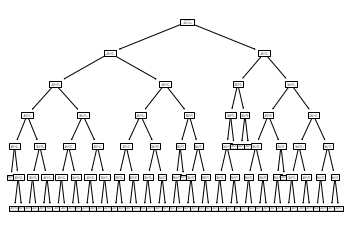

In [153]:
tree.plot_tree(dt_Class_model)

## Comparison of algorithm